## Fid drift mon

The fid_drift_mon database is used to
   * plot per-observation fid "drift" by plotting the end-of-observation median fid position as offset from the overall multi-observation median
   * plot per-observation offsets between the beginning-of-observation fid positions and the starcheck catalog positions

This PR is an update to fetch these data with Python methods, save in a sqlite3 table (similar to the previous Sybase table), and regularly update plots.  The PR also effects updates to the plotting to catch up with the data and operational practices, for example the limit lines on the plot of the fid lights relative to the starcheck catalog positions reflect the updated/current fid search box size, and the overall median of the drift plots has been updated to the 2010-2020 data instead of the 2002 data.

Review of the updated output plots from the tools and the data in the new fid_stats.db3 database shows that the new data is acceptable for the above trending purposes.

In [1]:
import os
os.environ['SKA'] = '/proj/sot/ska'
from astropy.table import Table, join
from cxotime import CxoTime
import numpy as np
import matplotlib.pyplot as plt
from ska_matplotlib import plot_cxctime
from mica.archive.cda import get_ocat_local
import ska_dbi
from kadi.commands import get_observations

In [2]:
%matplotlib inline

To compare with the previous database, I extracted a data table from sybase with

      import ska_dbi
      from astropy.table import Table
      db = ska_dbi.DBI(dbi='sybase', user='aca_read')
      dat = db.fetchall("select * from fid_stats")
      Table(dat).write('sybase_fid_stats.dat', format='ascii')


In [3]:
# Data from the Sybase perl job
#olddat = Table.read("https://icxc.cfa.harvard.edu/aspect/test_review_outputs/fid_drift_mon-pr15/sybase_fid_stats.dat",
#                    format='ascii')
olddat = Table.read('sybase_fid_stats.dat', format='ascii')

In [4]:
# Data from the sqlite job in this PR
with ska_dbi.DBI(server='fid_stats.db3', dbi='sqlite') as db:
    newdat = Table(db.fetchall("select * from fid_stats"))

In [5]:
# First confirm that the data over the last years is complete, with the Sybase table as the reference
recentnew = newdat[newdat['tstart'] > CxoTime('2019:001').secs]
recentold = olddat[olddat['tstart'] > CxoTime('2019:001').secs]
missing_new = list(set(recentold['obsid']) - set(recentnew['obsid']))
len(missing_new)

16

In [6]:
missing_new

[22140,
 24252,
 26787,
 25892,
 25445,
 29029,
 24520,
 22668,
 27724,
 24883,
 26643,
 26166,
 23290,
 22139,
 22652,
 23291]

The new table of data is missing several observations compared to the Perl/Sybase table.  This is acceptable.
I note for example that observation 22668 was "canceled".  I'll take an action to review why the other observations are missing -- I think some are undercover observations.  But a few "missing" observations in the new table are fine for its
trending purposes, and the gold standard of the Sybase table may in fact be incorrect to have these observations in there.

In [7]:
# I could have done a fancy join but here I've just looped over the new data and matched it a row at a time
# to the old data
annotate_new = []
for row in newdat:
    info = {}
    oldmatch = olddat[(olddat['obsid'] == row['obsid']) & (olddat['id_string'] == row['id_string'].strip())]
    info['obsid'] = row['obsid']
    info['oldmatches'] = len(oldmatch)
    if len(oldmatch) == 0:
        info['o_tstart'] = -1
        info['o_ang_y_med'] = -1
        info['o_ang_z_med'] = -1
        info['o_mag_med'] = -1
        info['o_mag_i_avg'] = -1
        info['o_exp_time'] = -1
    else:  
        info['o_tstart'] = oldmatch['tstart'][0]
        info['o_ang_y_med'] = oldmatch['ang_y_med'][0]
        info['o_ang_z_med'] = oldmatch['ang_z_med'][0]
        info['o_mag_med'] = oldmatch['mag_med'][0]
        info['o_mag_i_avg'] = oldmatch['mag_i_avg'][0]
        info['o_exp_time'] = oldmatch['exp_time'][0]
    annotate_new.append(info)   

# And then I've added the new columns to the new data
annotate_new = Table(annotate_new)
newdat_a = newdat.copy()
newdat_a['o_tstart'] = annotate_new['o_tstart']
newdat_a['o_ang_y_med'] = annotate_new['o_ang_y_med']
newdat_a['o_ang_z_med'] = annotate_new['o_ang_z_med']
newdat_a['o_mag_med'] = annotate_new['o_mag_med']
newdat_a['o_mag_i_avg'] = annotate_new['o_mag_i_avg']
# new database just has exposure time in seconds, multiply the old ks value by 1000 to match
newdat_a['o_exp_time'] = annotate_new['o_exp_time'] * 1000


In [8]:
from fid_drift_mon.plot_drift import EXCLUDE_OBSIDS

In [9]:
EXCLUDE_OBSIDS

[2010,
 2783,
 1431,
 1411,
 11051,
 2733,
 2194,
 3472,
 7587,
 16630,
 3582,
 3988,
 16314]

In [10]:
obsids = EXCLUDE_OBSIDS + [16314, 21167, 20980, 27160, 27520, 2943]

In [11]:
ok = ((newdat_a['o_tstart'] != -1) & ~np.in1d(newdat['obsid'], obsids) & (newdat_a['o_exp_time'] > 500))

Comparing the new numeric values to the previous values there are some offsets.  I don't completely understand the 
patterns, but I think this has to do with small changes in fid positions in different aspect level 1 processing versions
and with small changes in the samples selected. If we wanted to nail this down completely, we could perhaps rerun the Perl code on the current aspect level 1 data for the historic observations.  However, given that the purpose of the database is to trend changes on the 10-40 arcsec level, these changes on the .1 to 1.5 arcsec level are basically irrelevant.

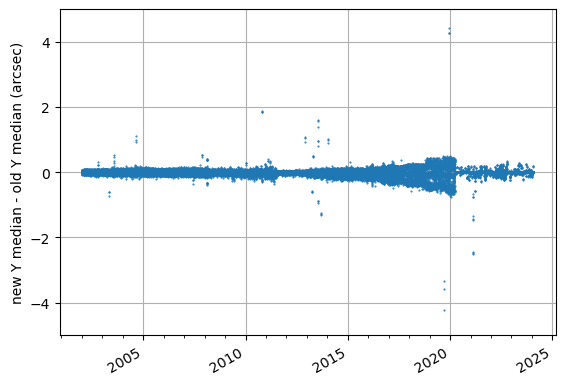

In [12]:
plot_cxctime(newdat_a['tstart'][ok], newdat_a['ang_y_med'][ok] - newdat_a['o_ang_y_med'][ok], '.', markersize=1);
plt.grid();
plt.ylim(-5, 5)
plt.ylabel('new Y median - old Y median (arcsec)');

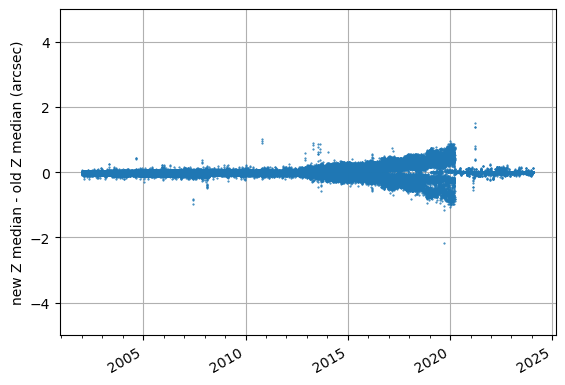

In [13]:
plot_cxctime(newdat_a['tstart'][ok], newdat_a['ang_z_med'][ok] - newdat_a['o_ang_z_med'][ok], '.', markersize=1);
plt.ylim(-5, 5)
plt.grid();
plt.ylabel('new Z median - old Z median (arcsec)');

The magnitude information appears qualitatively the same (as one would expect).

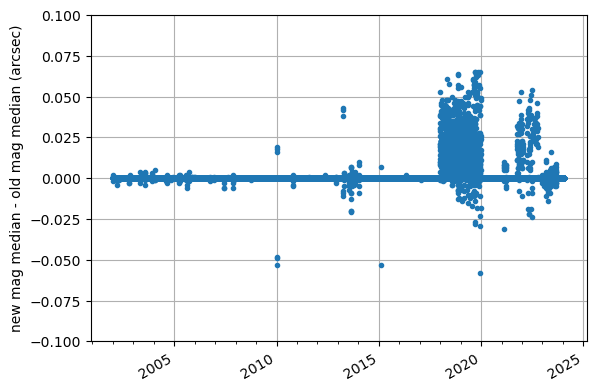

In [14]:
plot_cxctime(newdat_a['tstart'][ok], newdat_a['mag_med'][ok] - newdat_a['o_mag_med'][ok], '.')
plt.grid();
plt.ylim(-.1, .1)
plt.ylabel('new mag median - old mag median (arcsec)');

Overall, the new data are reasonable for trending.